In [1]:
# setup installation
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
# Import the classes
from Agent import Agent
from model import DQN
from ReplayBuffer import ReplayBuffer

In [3]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import torch

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# Initialize the environment
env = UnityEnvironment("/data/Banana_Linux_NoVis/Banana.x86_64")

# Check the brain name
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


In [7]:
# Hyperparameters
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 64          # minibatch size
GAMMA = 0.99             # discounting the rewards
LR = 5e-3                # learning rate for the agent
UPDATE_EVERY = 5         # how often to update the network
TAU = 1e-3               # for soft update of target parameters

In [8]:
# Train loop

def train_agent(n_episodes, max_t, epsilon_start, epsilon_end, epsilon_decay):
    # Initialize the agent
    agent = Agent(state_size=37, action_size=4, device=device, buffer_size=BUFFER_SIZE, gamma=GAMMA, batch_size=BATCH_SIZE, tau=TAU, lr=LR, update_every=UPDATE_EVERY, fc1=128, fc2=256, fc3=64)
    # Initilalize the scores list
    scores = []
    scores_window = deque(maxlen=100)
    epsilon = epsilon_start
    # Start the episodes
    for episode in range(1, n_episodes):
        # Reset the environment
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        # start the time steps in an episode
        for t in range(max_t):
            # select the action
            action = agent.act(state, epsilon)
            # Get the next state, reward, done
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            # Agent takes a step, adds the experience and learns
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        epsilon = max(epsilon_end, epsilon_decay*epsilon)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        if episode%100==0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break

        # Save the model weights
        torch.save(agent.local_nw.state_dict(), "weights.pt")
    return scores

In [9]:
res_scores = train_agent(1_800, 1_000, 1.0, 0.01, 0.995)

Episode 100	Average Score: -0.05
Episode 200	Average Score: 0.191
Episode 300	Average Score: 0.24
Episode 400	Average Score: 0.11
Episode 500	Average Score: 0.29
Episode 600	Average Score: 0.19
Episode 700	Average Score: 0.19
Episode 800	Average Score: 0.14
Episode 900	Average Score: 0.30
Episode 1000	Average Score: -0.02
Episode 1100	Average Score: 0.072
Episode 1200	Average Score: -0.04
Episode 1300	Average Score: 0.051
Episode 1400	Average Score: 0.141
Episode 1500	Average Score: 0.25
Episode 1600	Average Score: 0.09
Episode 1700	Average Score: 0.19
Episode 1799	Average Score: 0.09

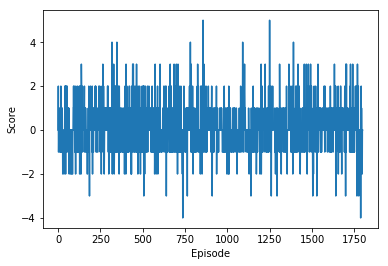

In [11]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(res_scores)), res_scores)
plt.ylabel('Score')
plt.xlabel("Episode")
plt.show()